In [133]:
import re
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [134]:
primaryColor = '#fd4d58'
secondaryColor = '#969494'
sns.set(style='white', font='SimHei', font_scale=2)

# 【 Dataset 】

dataset From inside airbnb - http://insideairbnb.com/get-the-data.html

In [135]:
calenderData = pd.read_csv('./data/calendar.csv', parse_dates=['date'])
listingData = pd.read_csv('./data/listings.csv')
reviewData = pd.read_csv('./data/reviews.csv')

Data Preprocessing

In [136]:
def getPrice(price: str):
    priceRe = r'([0-9]*)'
    matchObj = re.match(priceRe, re.sub(r'[$,]', '', price))
    price = int(matchObj.groups(0)[0]) if matchObj else 0
    return price

In [137]:
min(calenderData['date']), max(calenderData['date'])

(Timestamp('2021-10-30 00:00:00'), Timestamp('2022-10-30 00:00:00'))

In [138]:
calenderData = calenderData[calenderData['date'] >= '2021-11-01'] # 取 2021-11 月初 -  2022-10 月底 
listingData['price'] = listingData['price'].map(getPrice)

Data Check

In [139]:
from NBprocessing import NBgeneral

In [140]:
NBgeneral.missing_values(listingData).head(10)

,#Missing_values,%Missing_values
neighbourhood_group_cleansed,4545,100.0
license,4545,100.0
calendar_updated,4545,100.0
bathrooms,4545,100.0
neighbourhood,2027,44.6
neighborhood_overview,2027,44.6
host_about,1649,36.3
host_response_time,1506,33.1
host_response_rate,1506,33.1
review_scores_value,1299,28.6


# 【 Overview 】

### Listing Price Distribution for one night

In [141]:
ranges = [i*1000 for i in range(15)]
listingPriceRangCount = listingData['price'].groupby(pd.cut(listingData['price'], ranges)).count()
intervalLeft = [key.left for key in listingPriceRangCount.keys()]

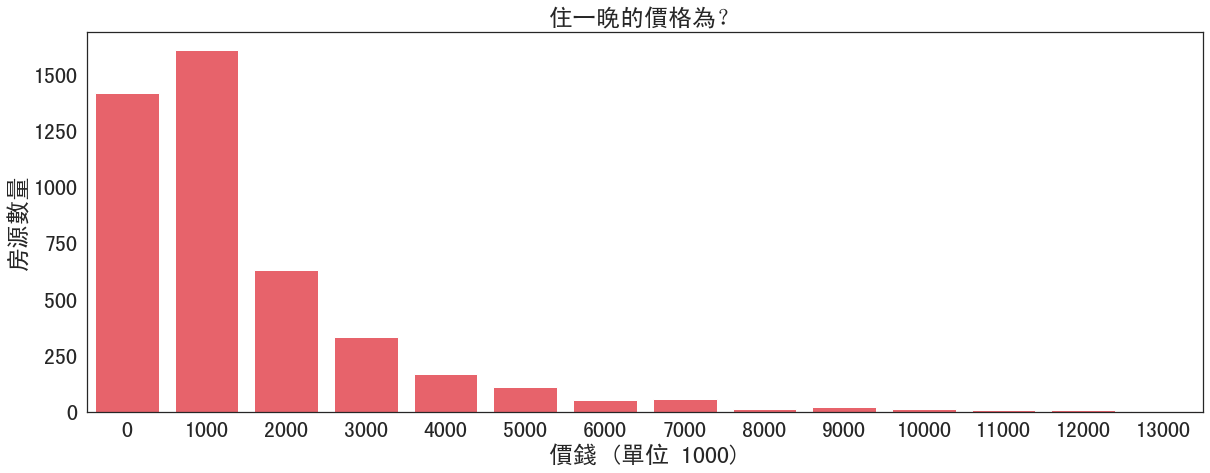

In [142]:
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 7))
sns.barplot(data = listingPriceRangCount, x = intervalLeft, y = listingPriceRangCount.values, color = primaryColor).set_title("住一晚的價格為？")
ax1.set(xlabel='價錢 (單位 1000)', ylabel='房源數量')
plt.savefig(f"./output/listingPriceRangeDistribution.png", dpi=1200, facecolor=fig.get_facecolor())

In [143]:
len(listingData), len(listingData[listingData['price'] > 8000])

(4545, 149)

In [144]:
totalListingCount = calenderData.groupby([pd.Grouper(key='date', freq='M')]).agg(listingIdCount = ('listing_id','count')).reset_index()
stateListingCount = calenderData.groupby([pd.Grouper(key='date', freq='M'), 'available']).agg(listingIdCount = ('listing_id','count')).reset_index().sort_values('available', ascending=False)
supplyAndDemandListingCount = totalListingCount.merge(stateListingCount[stateListingCount['available'] == "f"], how='left', on='date', suffixes=('_total', '_booked'))
supplyAndDemandListingCount.sort_values('date', inplace=True)

### House Supply & Demand

[Text(0, 0, '2021-11-30'),
 Text(1, 0, '2021-12-31'),
 Text(2, 0, '2022-01-31'),
 Text(3, 0, '2022-02-28'),
 Text(4, 0, '2022-03-31'),
 Text(5, 0, '2022-04-30'),
 Text(6, 0, '2022-05-31'),
 Text(7, 0, '2022-06-30'),
 Text(8, 0, '2022-07-31'),
 Text(9, 0, '2022-08-31'),
 Text(10, 0, '2022-09-30'),
 Text(11, 0, '2022-10-31')]

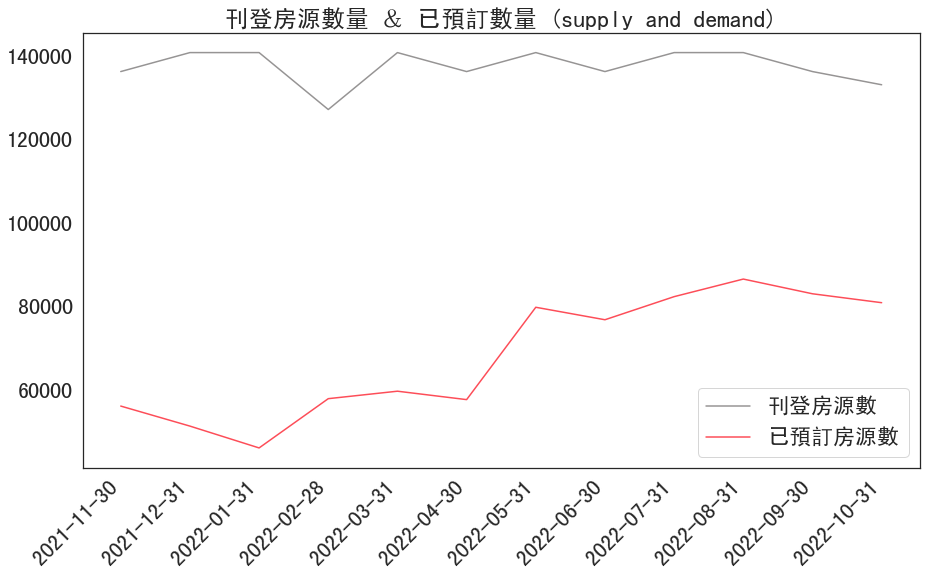

In [145]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15,8))
xData = supplyAndDemandListingCount['date'].dt.strftime('%Y-%m-%d')
yData_total = supplyAndDemandListingCount['listingIdCount_total']
yData_booked = supplyAndDemandListingCount['listingIdCount_booked']
ax1.plot(xData, yData_total, label = "刊登房源數", color=secondaryColor)
ax1.plot(xData, yData_booked,label = "已預訂房源數", color=primaryColor)
ax1.set_title("刊登房源數量 ＆ 已預訂數量 (supply and demand)")
ax1.legend()
ax1.set_xticklabels(labels=xData, rotation=45, ha='right')
# plt.savefig(f"./output/totalListingCount.png", dpi=1200, facecolor=fig.get_facecolor())

###  Neighbourhood & Total Listing Count 

In [146]:
neighbourhoodCount = listingData.groupby(['neighbourhood_cleansed'], as_index=False).agg(listingCount = ('id','count')).sort_values('listingCount', ascending = False)
neighbourhoodCount.head(3)

,neighbourhood_cleansed,listingCount
11,萬華區,866
1,中正區,863
8,大安區,732


[Text(0.5, 0, '行政區域'), Text(0, 0.5, '房源數量')]

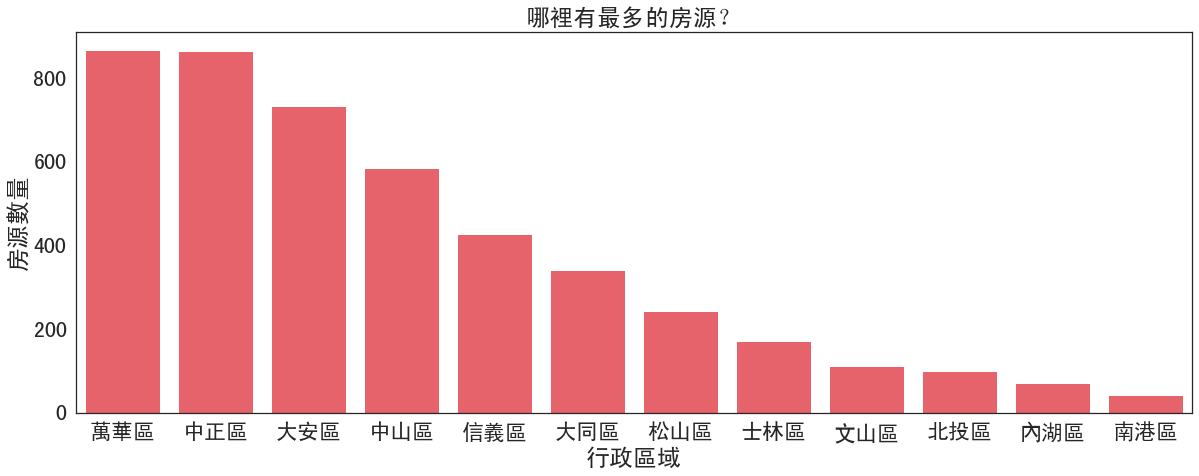

In [147]:
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 7))
sns.barplot(data = neighbourhoodCount, x = 'neighbourhood_cleansed', y = 'listingCount', color = primaryColor).set_title("哪裡有最多的房源？")
ax1.set(xlabel="行政區域", ylabel="房源數量")
# plt.savefig(f"./output/neighbourhoodListingCount.png", dpi=1200, facecolor=fig.get_facecolor())

Top3: 萬華區、中山區、大安區


remove outlier

In [148]:
q1, q98 = listingData['price'].quantile([0.01, 0.98])
generalPriceListingData = listingData[(q1 <= listingData['price']) & (q98 >= listingData['price'])]
print("remove listing count: ", len(listingData) - len(generalPriceListingData))

remove listing count:  136


###  Neighbourhood & Listing Price Distribution 

[Text(0.5, 0, '行政區域'), Text(0, 0.5, '價格')]

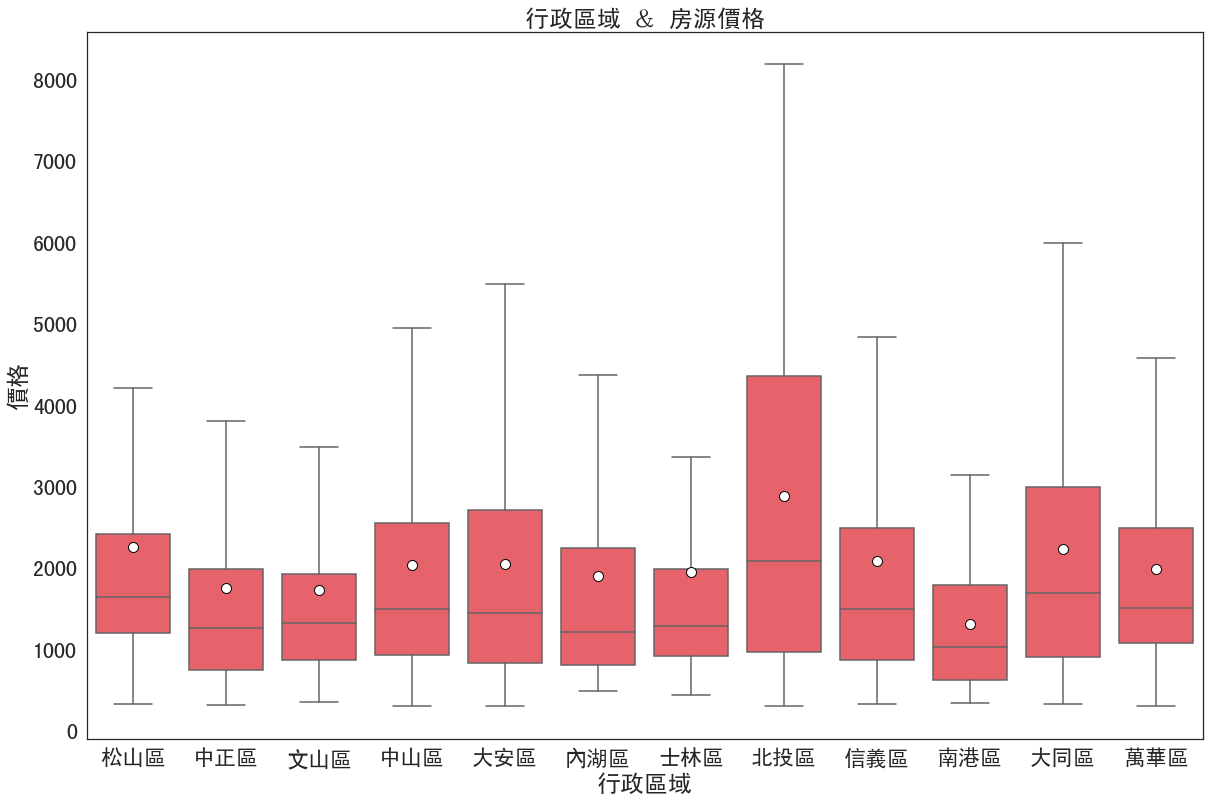

In [149]:
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 13))
sns.boxplot(data =generalPriceListingData, x="neighbourhood_cleansed", y="price", color = primaryColor, ax=ax1, showmeans = True, showfliers = False, meanprops={"marker":"o", "markerfacecolor":"white",  "markeredgecolor":"black", "markersize":"10"})\
    .set_title("行政區域 ＆ 房源價格")
ax1.set(xlabel="行政區域", ylabel="價格")
# plt.savefig(f"./output/generalNeighbourhoodPriceDistribution.png", dpi=1200, facecolor=fig.get_facecolor())

-> 最貴 - 北投區，最便宜 - 南港區

### 北投區 - Hot Spint Analysis

check if listing name or description include hotspring keywords


In [150]:
beitouLisingData = listingData[listingData['neighbourhood_cleansed']== '北投區']
beitouLisingData['hotSpring'] = False
hotSpringKeyWords = '溫泉|原湯|泡湯|地熱|Sweetme|hot spring'
for idx, row in beitouLisingData.iterrows():
    if re.search(hotSpringKeyWords, str(row['name'])+str(row['description'])):
        beitouLisingData.at[idx, 'hotSpring'] = True

In [151]:
hotSpringCount = beitouLisingData['hotSpring'].value_counts()
hotSpringCount

True     65
False    33
Name: hotSpring, dtype: int64

Text(0.5, 1.0, 'Hot Spring')

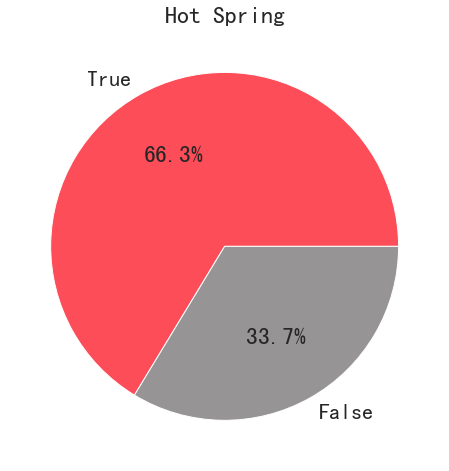

In [152]:
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 8))
ax1.pie(hotSpringCount.values, labels = hotSpringCount.keys(), colors=[primaryColor, secondaryColor], autopct='%1.1f%%')
ax1.set_title("Hot Spring")
# plt.savefig(f"./output/hotSpringPercentage.png", dpi=1200, facecolor=fig.get_facecolor())

Text(0.5, 1.0, '溫泉住宿')

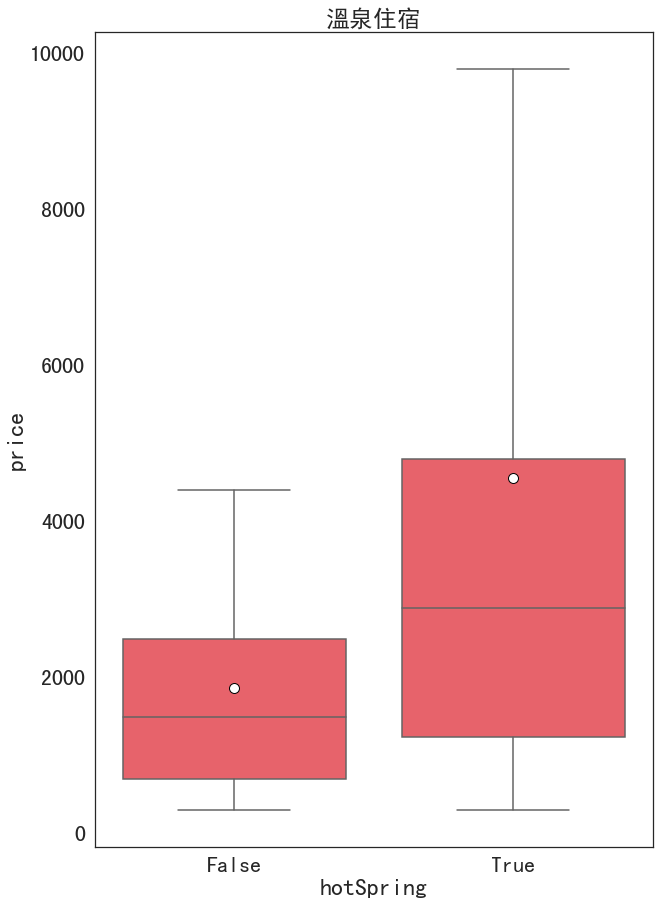

In [153]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 15))
sns.boxplot(data =beitouLisingData, x="hotSpring", y="price", color = primaryColor, ax=ax1, showmeans = True, showfliers = False, meanprops={"marker":"o", "markerfacecolor":"white",  "markeredgecolor":"black", "markersize":"10"})\
    .set_title("溫泉住宿")
# plt.savefig(f"./output/beitouPriceDistribution_hotSpring.png", dpi=1200, facecolor=fig.get_facecolor())

In [155]:
def getFirstNumFromStr(text):
    findNum = re.findall("\d+", str(text))
    return findNum[0] if findNum else 0

### Does Airbnb satisfy customer wants and needs ?

In [156]:
hostCols = ['host_acceptance_rate', 'host_listings_count']
reviewCols = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'review_scores_rating']
hostDf = listingData[['neighbourhood_cleansed'] + hostCols + reviewCols]
hostDf.loc[:]['host_acceptance_rate_numric'] = hostDf['host_acceptance_rate'].map(getFirstNumFromStr)
oneHotEncodingSuperhost = pd.get_dummies(listingData['host_is_superhost'], prefix='host_is_superhost_')
hostCols += list(oneHotEncodingSuperhost.columns)
hostDf.drop(['host_acceptance_rate', 'neighbourhood_cleansed'], axis = 1, inplace= True)

### review score rating 

Text(0.5, 1.0, 'review scores rating')

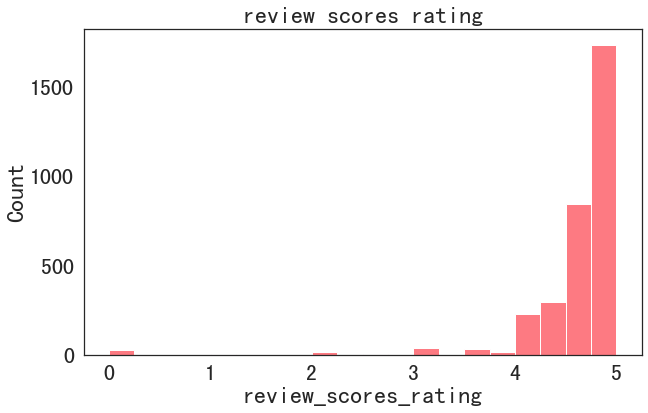

In [157]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(data=hostDf, x='review_scores_rating', binwidth=0.25, color = primaryColor)
ax1.set_title("review scores rating")
# plt.savefig(f"./output/reviewScoresRatingCount.png", dpi=1200, facecolor=fig.get_facecolor())

### review score rating ( <4 )

Text(0.5, 1.0, 'review scores rating (score < 4)')

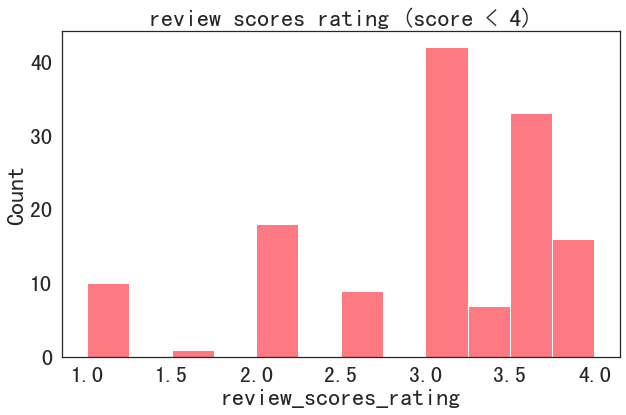

In [158]:
lowScoreRatingListingDat = listingData[listingData['review_scores_rating'] < 4].dropna(subset=reviewCols)
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(data=lowScoreRatingListingDat, x='review_scores_rating', binwidth=0.25, color = primaryColor)
ax1.set_title("review scores rating (score < 4)")
# plt.savefig(f"./output/lowReviewScoresRatingCount.png", dpi=1200, facecolor=fig.get_facecolor())

### Other reviwe-related scores for low (<4) review score rating listing 

[Text(-60, 0, '3.25'),
 Text(-60, 0, '3.29'),
 Text(-60, 0, '3.55'),
 Text(-60, 0, '3.85'),
 Text(-60, 0, '3.87'),
 Text(-60, 0, '4.13')]

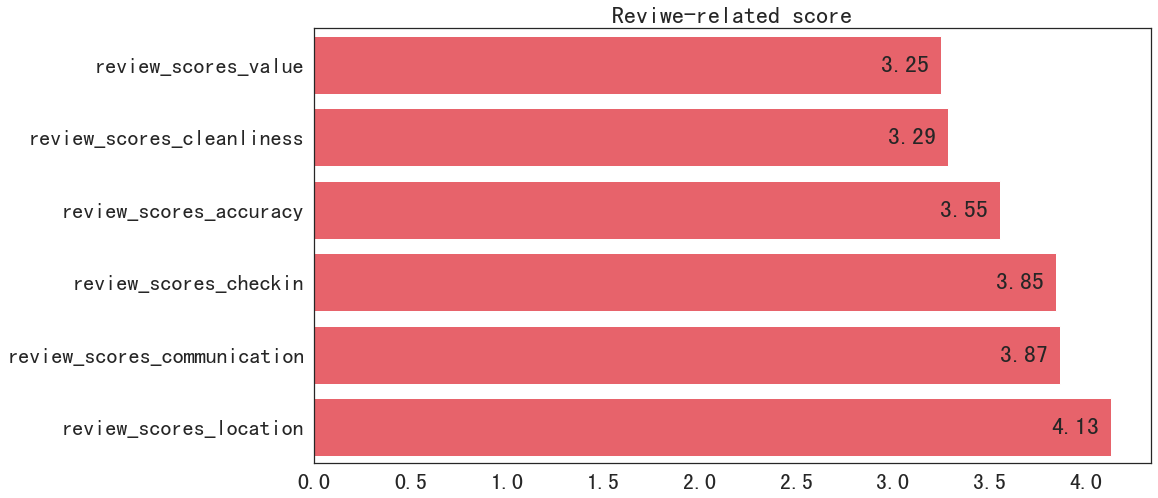

In [159]:
meanReviewInfo_lowScoreListing = lowScoreRatingListingDat[reviewCols].mean().sort_values()
meanReviewInfo_lowScoreListing.drop(['reviews_per_month', 'review_scores_rating'], axis=0, inplace=True)
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 8))
sns.barplot(y = meanReviewInfo_lowScoreListing.keys(), x = meanReviewInfo_lowScoreListing.values, orient='h', color = primaryColor).set_title('Reviwe-related score')
ax1.bar_label(ax1.containers[0], fmt="%.2f", padding=-60)
# plt.savefig(f"./output/meanReviewInfo_lowScoreListing.png", dpi=1200, facecolor=fig.get_facecolor())

### Who is probably be a good host ?  ( host_acceptance_rate, host_listings_count, host_is_superhost... )

### Correlation Coefficient for listing information

<AxesSubplot:>

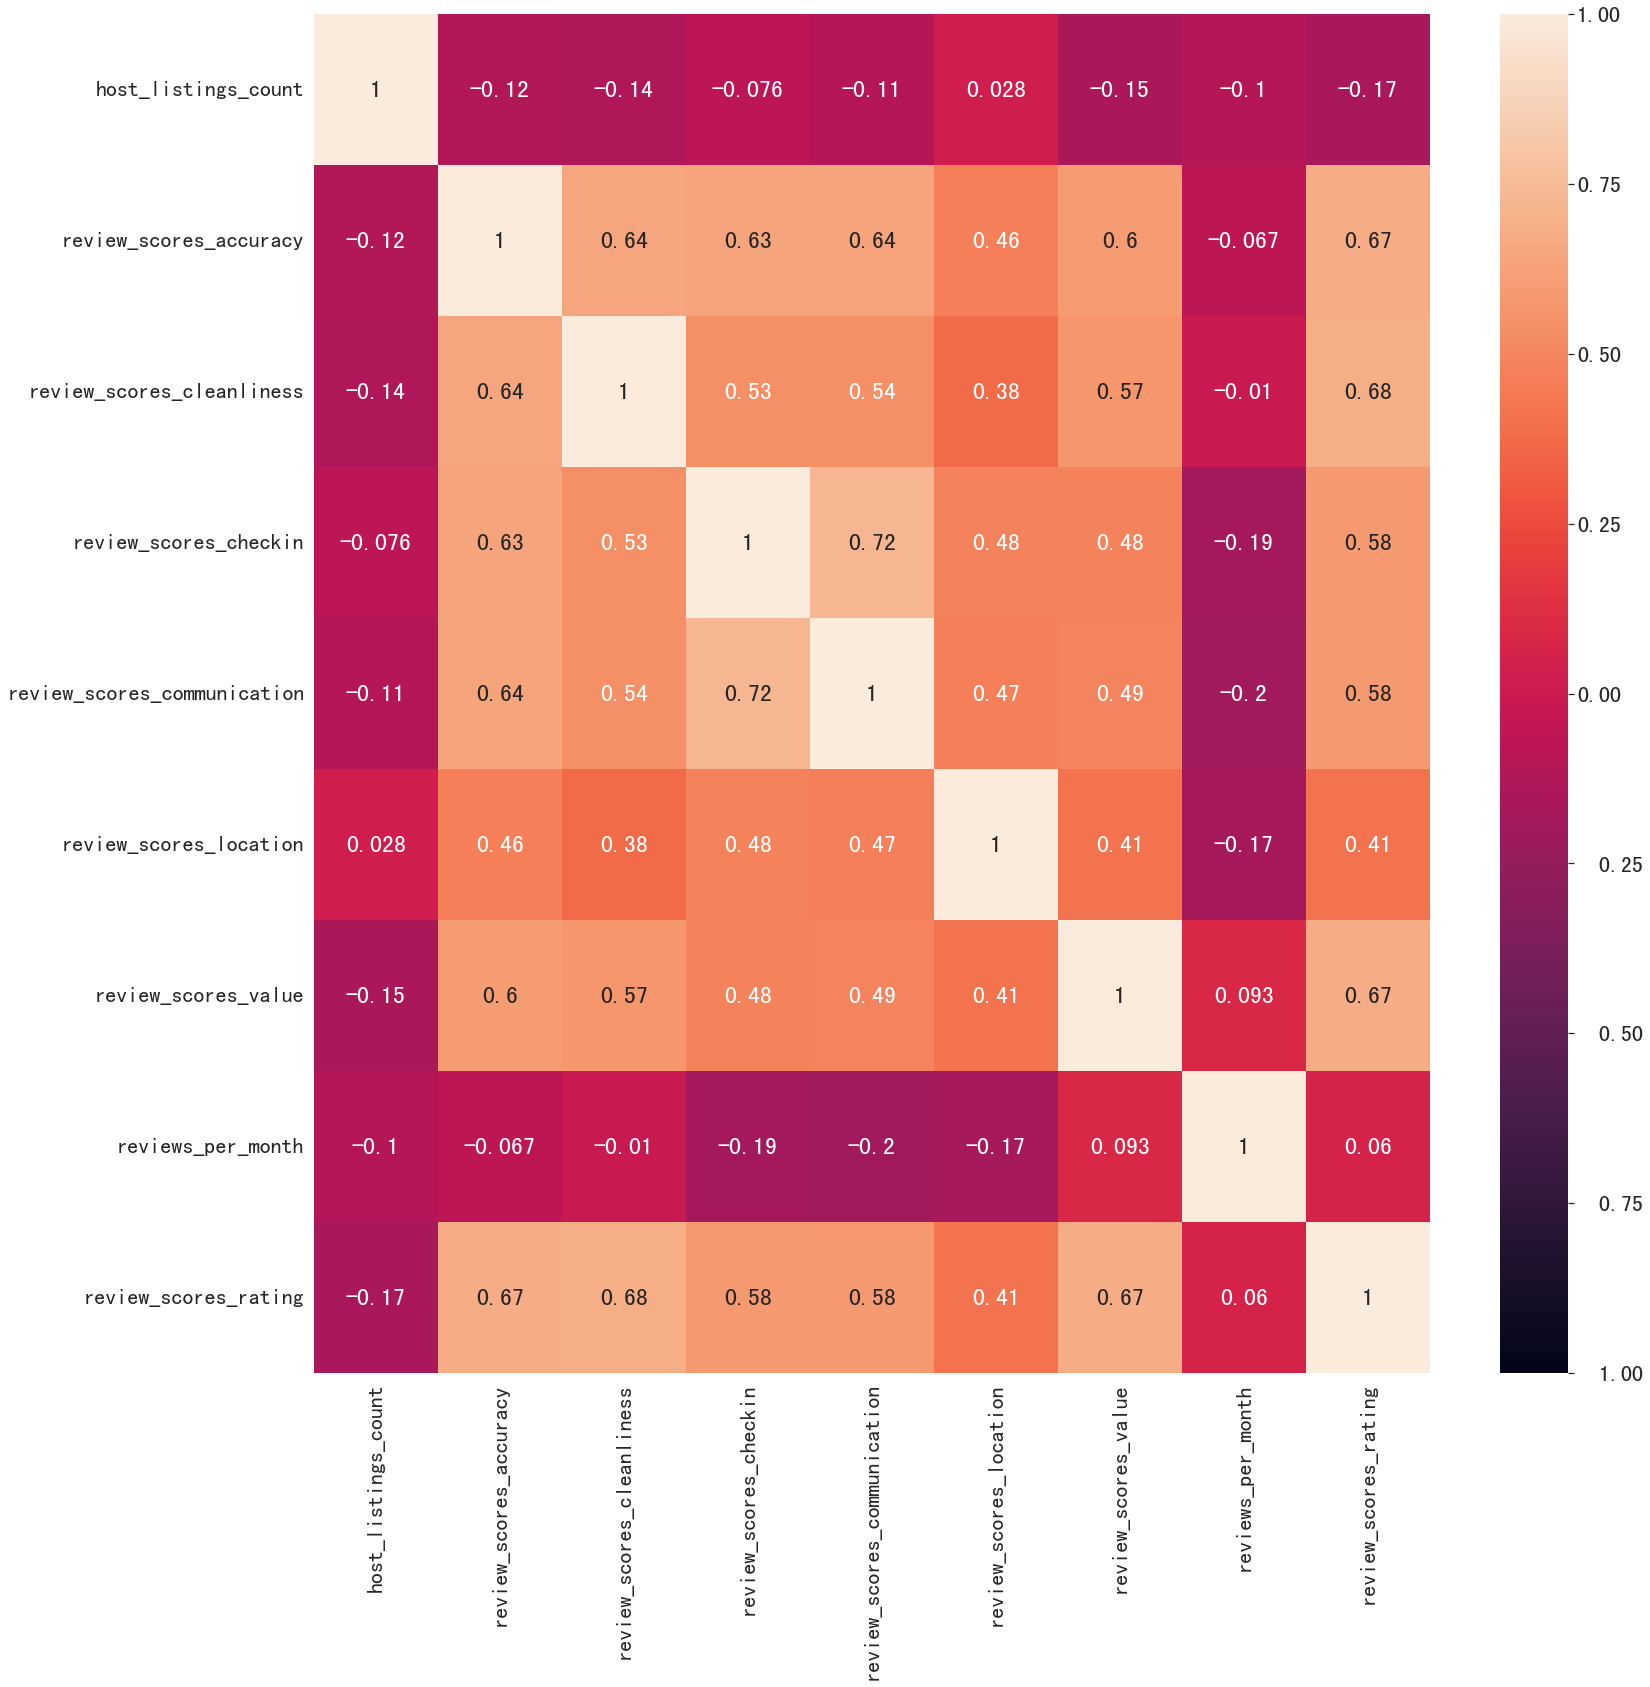

In [160]:
fig, (ax1) = plt.subplots(1, 1, figsize=(25, 25))
sns.heatmap(hostDf.corr(method='spearman'), vmin=-1, vmax=1, annot=True, ax=ax1)
# plt.savefig(f"./output/hostInfo_Corr_spearman_.png", dpi=1200, facecolor=fig.get_facecolor())

Super Host 

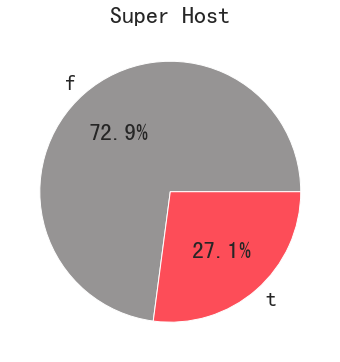

In [161]:
starHostCount = listingData['host_is_superhost'].value_counts()
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 6))
ax1.pie(starHostCount.values, labels = starHostCount.keys(), colors=[secondaryColor,primaryColor], autopct='%1.1f%%')
ax1.set_title("Super Host")
plt.savefig(f"./output/starHostPercentage.png", dpi=1200, facecolor=fig.get_facecolor())